<a href="https://colab.research.google.com/github/alina-bogdanovskaya/Data-Analysis_May2022/blob/lesson4/Data_Analysis_lesson4_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [165]:
!pip install binarytree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [166]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
from binarytree import Node as BT_Node
from matplotlib.colors import ListedColormap
from sklearn import datasets
from collections import Counter
import numpy as np
from sklearn import model_selection

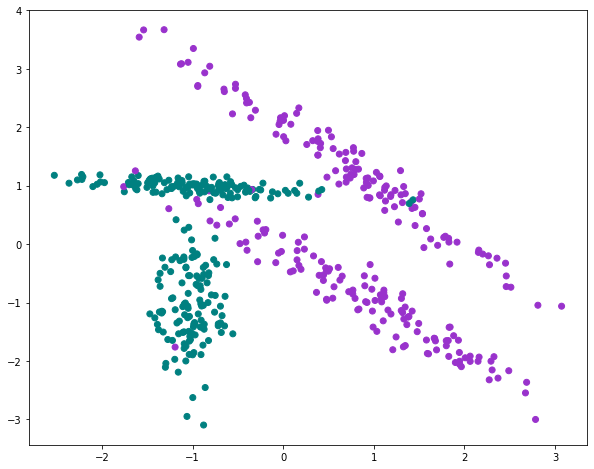

In [167]:
classification_data, classification_labels = datasets.make_classification(n_samples=500, n_features=2, n_informative=2, 
                                                                          n_classes=2, n_redundant=0, 
                                                                          n_clusters_per_class=2, random_state=3)

colors_g = ListedColormap(['teal', 'darkorchid'])
light_colors_g = ListedColormap(['azure', 'thistle'])
colors_s = ListedColormap(['seagreen', 'orangered'])
light_colors_s = ListedColormap(['palegreen', 'wheat'])

plt.figure(figsize=(10, 8))
plt.scatter(list(map(lambda x: x[0], classification_data)), 
            list(map(lambda x: x[1], classification_data)), 
            c=classification_labels, cmap=colors_g)

In [168]:
class Node:
  def __init__(self, index, t, true_branch, false_branch):
    self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
    self.t = t  # значение порога
    self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
    self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

  def __str__(self):
    return f'Индекс: {self.index},\\n порог: {self.t}'

  def __repr__(self):
    return f'Индекс: {self.index},\\n порог: {self.t}'
        

class Leaf:
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels
    self.classes = Counter(self.labels)
    self.prediction = self.predict()
    self.prob_class1 = self.classes[1]/len(self.labels)
        
  def predict(self):
    prediction = self.classes.most_common()[0][0]
    return prediction

  def __str__(self):
    return f'Класс: {self.predict()}, \\n объектов класса 0: {self.classes[0]}, \\n объектов класса 1: {self.classes[1]}'

  def __repr__(self):
    return f'Класс: {self.predict()}, \\n объектов класса 0: {self.classes[0]}, \\n объектов класса 1: {self.classes[1]}'  


In [169]:
def gini(labels):
  classes = {}
  for label in labels:
    if label not in classes:
      classes[label] = 0
    classes[label] += 1
      
  impurity = 1
  for label in classes:
    p = classes[label] / len(labels)
    impurity -= p ** 2
          
  return impurity


def entropy(labels):
  classes = Counter(labels)
  impurity = 0
  for label in classes:
    p = classes[label] / len(labels)
    impurity -= p * np.log(p)

  return impurity


def quality(left_labels, right_labels, current_criterion, criterion):
  p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
  return current_criterion - p * criterion(left_labels) - (1 - p) * criterion(right_labels)


def split(data, labels, index, t):
  left = np.where(data[:, index] <= t)
  right = np.where(data[:, index] > t)
        
  true_data = data[left]
  false_data = data[right]
  true_labels = labels[left]
  false_labels = labels[right]
        
  return true_data, false_data, true_labels, false_labels


def find_best_split(data, labels, criterion):
  min_leaf = 5
  current_criterion = criterion(labels)

  best_quality = 0
  best_t = None
  best_index = None
    
  n_features = data.shape[1]
    
  for index in range(n_features):
    t_values = np.unique([row[index] for row in data])
        
    for t in t_values:
      true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
      if len(true_data) < min_leaf or len(false_data) < min_leaf:
        continue
            
      current_quality = quality(true_labels, false_labels, current_criterion, criterion)
            
      if current_quality > best_quality:
        best_quality, best_t, best_index = current_quality, t, index

  return best_quality, best_t, best_index


def build_tree(data, labels, criterion):
  quality, t, index = find_best_split(data, labels, criterion)
  
  if quality == 0:
    return Leaf(data, labels)

  true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

  true_branch = build_tree(true_data, true_labels, criterion)
  false_branch = build_tree(false_data, false_labels, criterion)

  return Node(index, t, true_branch, false_branch)


def classify_object(obj, node):
  if isinstance(node, Leaf):
    answer = node.prediction, node.prob_class1
    return answer

  if obj[node.index] <= node.t:
    return classify_object(obj, node.true_branch)
  else:
    return classify_object(obj, node.false_branch)
    
    
def predict(data, tree):
  classes = []
  
  for obj in data:
    prediction = classify_object(obj, tree)[0]
    classes.append(prediction)
  return np.array(classes)

def probability(data, tree):
  probs = []
  
  for obj in data:
    prob = classify_object(obj, tree)[1]
    probs.append(prob)
  
  return np.array(probs)


In [170]:
def convert_tree(node):
  if node is None:
    return None
  if isinstance(node, Leaf):
    return BT_Node(f'{node}')  
  else:
    bt_node = BT_Node(f'{node}', convert_tree(node.true_branch), convert_tree(node.false_branch))
  return bt_node

In [171]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                    classification_labels, 
                                                                                    test_size = 0.3,
                                                                                    random_state = 1)

# Построим дерево по обучающей выборке
my_tree_gini = build_tree(train_data, train_labels, criterion=gini)
my_tree_entropy = build_tree(train_data, train_labels, criterion=entropy)

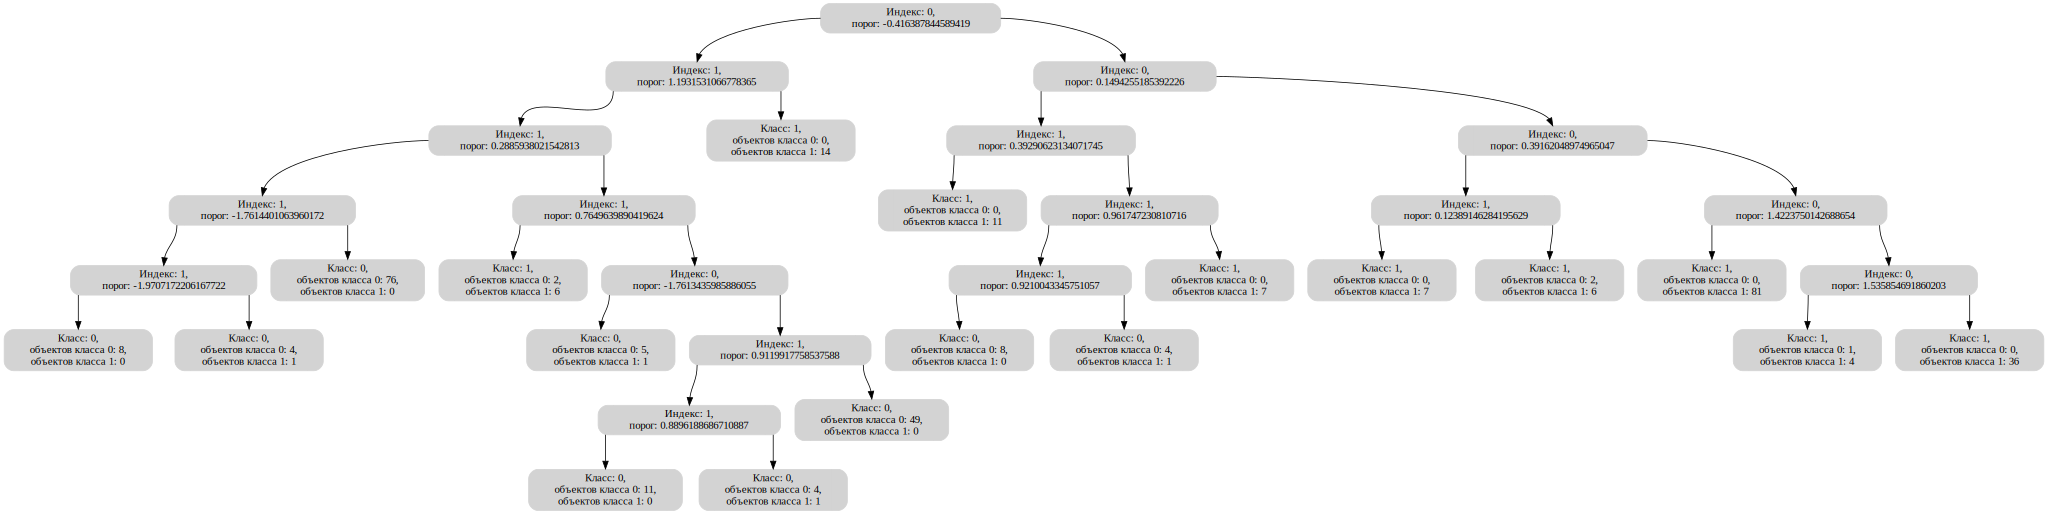

In [172]:
convert_tree(my_tree_gini)

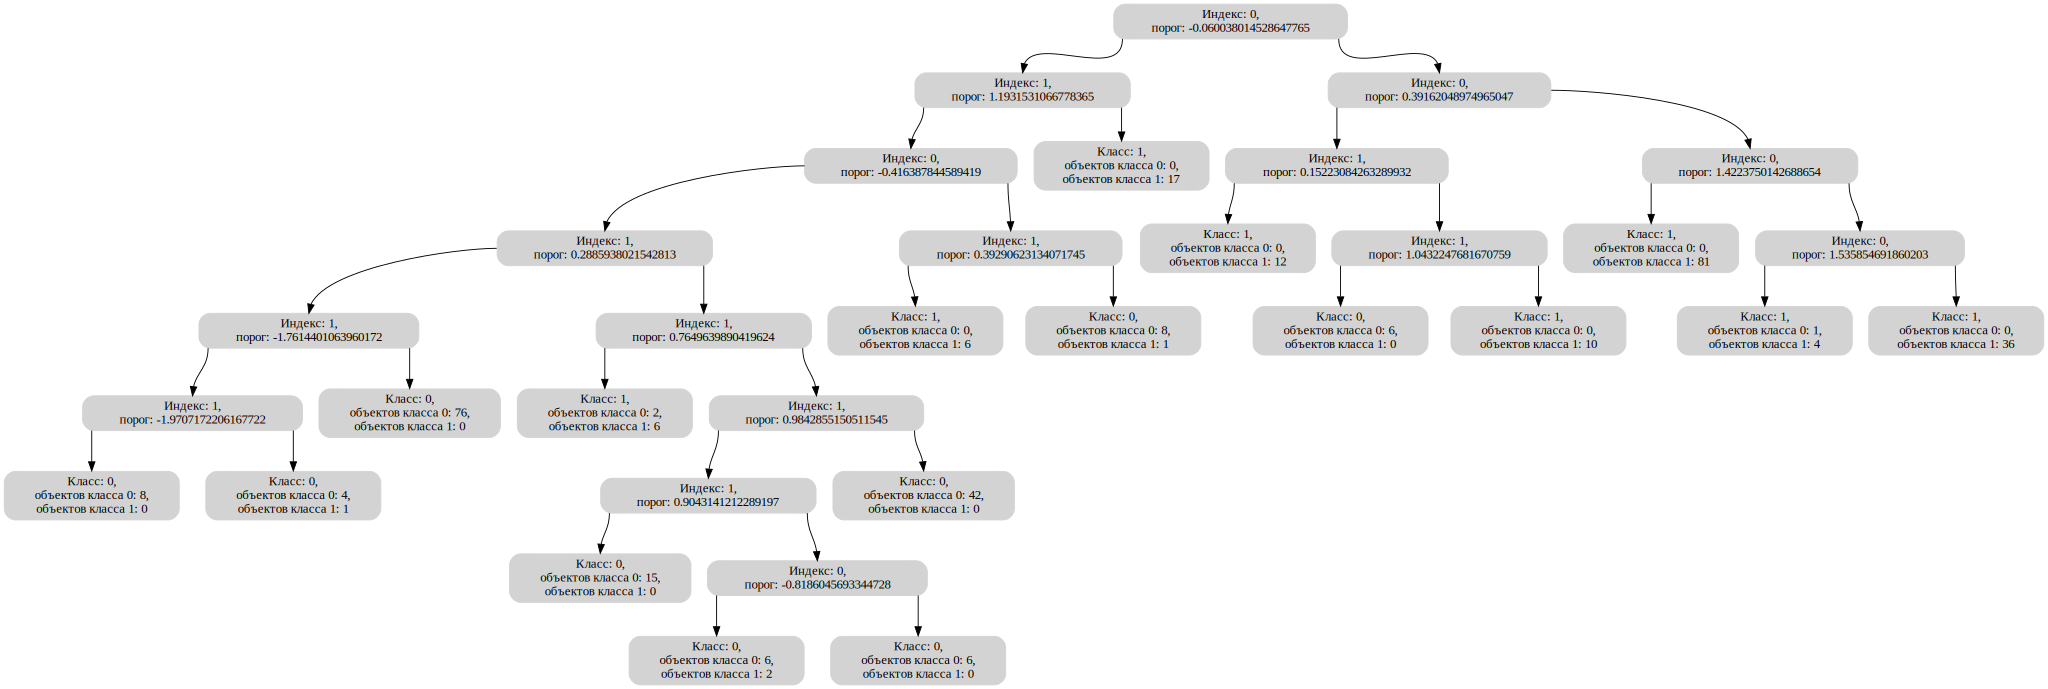

In [173]:
convert_tree(my_tree_entropy)

In [174]:
train_answers_gini = predict(train_data, my_tree_gini)
train_answers_entropy = predict(train_data, my_tree_entropy)

test_answers_gini = predict(test_data, my_tree_gini)
test_answers_entropy = predict(test_data, my_tree_entropy)

In [175]:
def accuracy_metric(actual, predicted):
  return np.sum(actual==predicted)/len(actual)

def balanced_accuracy_metric(actual, predicted):
  true_predicted = (actual==predicted).astype(int)
  sensitivity = np.sum(actual * true_predicted)/np.sum(actual==1)
  specificity = np.sum((1-actual) * true_predicted)/np.sum(actual==0)
  return 0.5 * (sensitivity + specificity)

In [176]:
print(f'При использовании индекса Джини в качестве критерия информативности:' + 
      f'\n  точность на обучающей выборке  = {accuracy_metric(train_labels, train_answers_gini)},' +
      f'\n  сбалансированная точность на обучающей выборке = {balanced_accuracy_metric(train_labels, train_answers_gini)},' +
      f'\n  точность на тестовой выборке  = {accuracy_metric(test_labels, test_answers_gini)},' +
      f'\n  сбалансированная точность на тестовой выборке = {balanced_accuracy_metric(test_labels, test_answers_gini)}')

При использовании индекса Джини в качестве критерия информативности:
  точность на обучающей выборке  = 0.9742857142857143,
  сбалансированная точность на обучающей выборке = 0.9742685475444096,
  точность на тестовой выборке  = 0.9666666666666667,
  сбалансированная точность на тестовой выборке = 0.966109233232521


In [177]:
print(f'При использовании энтропии Шеннона в качестве критерия информативности:' + 
      f'\n  точность на обучающей выборке  = {accuracy_metric(train_labels, train_answers_entropy)},' +
      f'\n  сбалансированная точность на обучающей выборке = {balanced_accuracy_metric(train_labels, train_answers_entropy)},' +
      f'\n  точность на тестовой выборке  = {accuracy_metric(test_labels, test_answers_entropy)},' +
      f'\n  сбалансированная точность на тестовой выборке = {balanced_accuracy_metric(test_labels, test_answers_entropy)}')

При использовании энтропии Шеннона в качестве критерия информативности:
  точность на обучающей выборке  = 0.98,
  сбалансированная точность на обучающей выборке = 0.9800156739811912,
  точность на тестовой выборке  = 0.9733333333333334,
  сбалансированная точность на тестовой выборке = 0.9733143568760008


In [178]:
train_accuracy_gini = accuracy_metric(train_labels, train_answers_gini)
test_accuracy_gini = accuracy_metric(test_labels, test_answers_gini)

train_accuracy_entropy = accuracy_metric(train_labels, train_answers_entropy)
test_accuracy_entropy = accuracy_metric(test_labels, test_answers_entropy)

In [179]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

Text(0.5, 1.0, 'Test accuracy, GI=0.97')

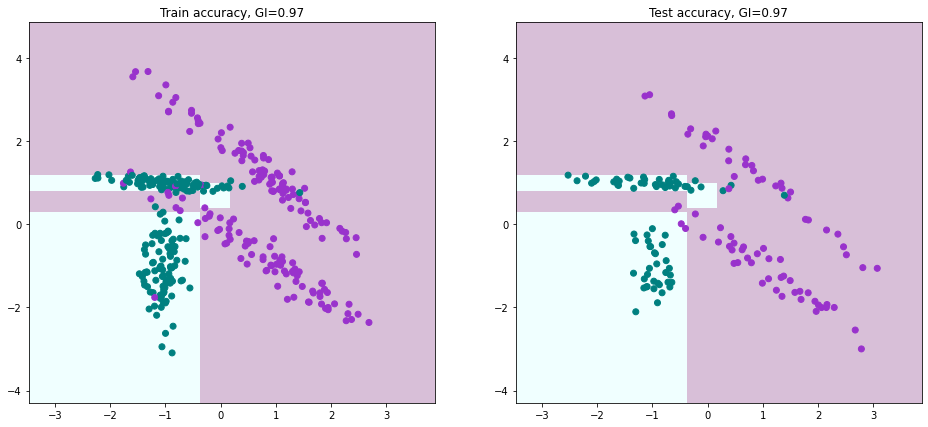

In [180]:
# Критерий информативности - индекс Джини
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_gini)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors_g)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors_g)
plt.title(f'Train accuracy, GI={train_accuracy_gini:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors_g)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors_g)
plt.title(f'Test accuracy, GI={test_accuracy_gini:.2f}')

Text(0.5, 1.0, 'Test accuracy, SE=0.97')

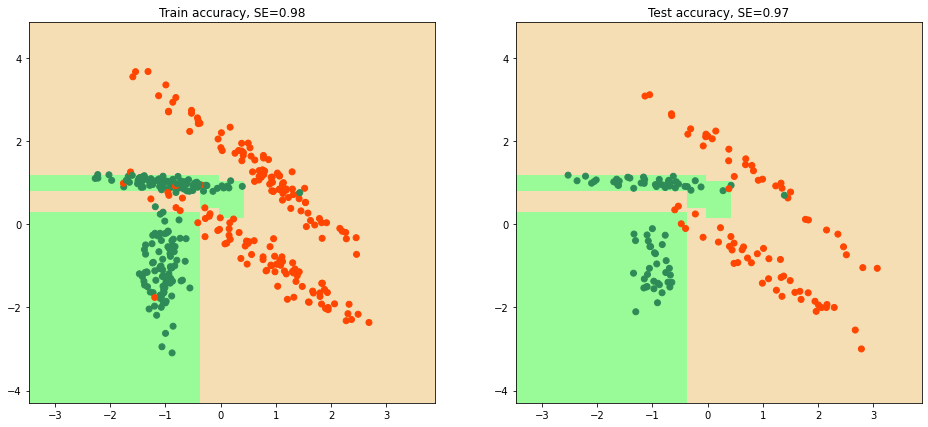

In [181]:
# Критерий информативности - энтропия Шеннона
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_entropy)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors_s)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors_s)
plt.title(f'Train accuracy, SE={train_accuracy_entropy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors_s)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors_s)
plt.title(f'Test accuracy, SE={test_accuracy_entropy:.2f}')

При использовании в качестве критерия информативности энтропии Шеннона точность модели на обучающей выборке незначительно превосходит таковую для индекса Джини. На тестовой выборке чуть большую точность также показывает модель с использованием энтропии Шеннона. 

In [182]:
# Реализуем построение дерева с ограничением глубины
def build_tree_limited_depth(data, labels, max_depth, cur_depth=0, criterion=gini):
  quality, t, index = find_best_split(data, labels, criterion=gini)
  
  if quality == 0:
    return Leaf(data, labels)
    
  if cur_depth >= max_depth: 
    return Leaf(data, labels)
    
  true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

  true_branch = build_tree_limited_depth(true_data, true_labels, max_depth, cur_depth + 1)
  false_branch = build_tree_limited_depth(false_data, false_labels, max_depth, cur_depth + 1)

  return Node(index, t, true_branch, false_branch)

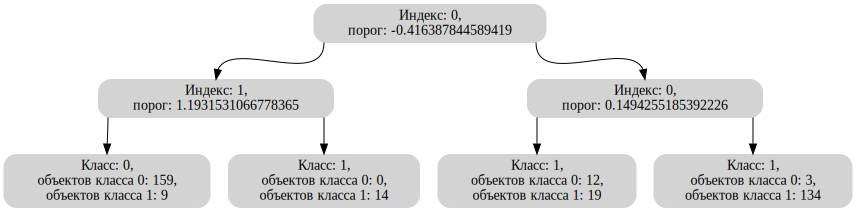

In [183]:
my_lim_tree = build_tree_limited_depth(train_data, train_labels, max_depth=2, criterion=gini)
convert_tree(my_lim_tree)

In [184]:
# Рассчитаем вероятность принадлежности объекта к классу на листья дерева по тестовой выборке
prob = probability(test_data, my_tree_gini)
order = np.argsort(prob)
y_sorted = test_labels[order]

bins_pos = y_sorted
bins_neg = 1 - y_sorted
num_pos, num_neg = np.sum(bins_pos), np.sum(bins_neg)
print(f'{num_pos} объектов 1 класса, {num_neg} объектов 0 класса')

TPR = np.concatenate([[0], np.cumsum(bins_neg)/num_neg])

FPR = np.concatenate([[0], np.cumsum(bins_pos)/num_pos])


77 объектов 1 класса, 73 объектов 0 класса


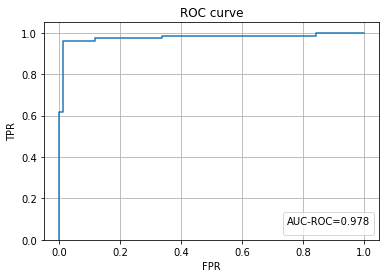

In [185]:
AUC_ROC = np.sum((FPR[1:] - FPR[:-1]) * (TPR[1:] + TPR[:-1])/2)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)

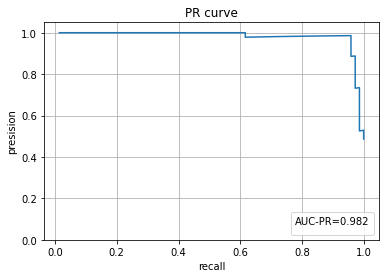

In [186]:
precision = np.cumsum(bins_neg)/(np.cumsum(bins_neg) + np.cumsum(bins_pos))
recall = TPR

AUC_PR = np.sum(precision * (recall[1:] - recall[:-1]))

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall[1:], precision)